In [1]:
# Import modules
import pandas as pd
import xarray as xr
import numpy as np
from netCDF4 import MFDataset, Dataset
import wrf
import sys
sys.path.append('/exports/csce/datastore/geos/users/s1878599/python_code/')
from WRFChemToolkit.analysis import aerosols_202 as aer, plots as pt, statistics as st
 
import warnings
warnings.filterwarnings('ignore')

# GEOS-Chem  

 4x5 deg simulation monthly outputs year 2017

In [2]:
data_pathGS = '/geos/d21/mmarvin/for_cate/geoschem_output_2017.nc'
GEOSchem = xr.open_mfdataset(data_pathGS)

data_pathWC = '/geos/d21/s1878599/IGP/outputs/autumn/wrfout*.nc'
WRFchem = xr.open_mfdataset(data_pathWC)

In [3]:
GEOSchem

<xarray.Dataset>
Dimensions:            (lat: 46, lev: 47, lon: 72, time: 12)
Coordinates:
  * lon                (lon) float64 -180.0 -175.0 -170.0 ... 165.0 170.0 175.0
  * lat                (lat) float64 -89.0 -86.0 -82.0 -78.0 ... 82.0 86.0 89.0
  * lev                (lev) float64 0.9925 0.9775 0.9624 ... 0.000127 2.763e-05
  * time               (time) datetime64[ns] 2017-01-01 ... 2017-12-01
Data variables:
    IJ_SOA_S_OC        (lev, lat, lon, time) float32 dask.array<chunksize=(47, 46, 72, 12), meta=np.ndarray>
    IJ_SOA_S_BC        (lev, lat, lon, time) float32 dask.array<chunksize=(47, 46, 72, 12), meta=np.ndarray>
    IJ_SOA_S_SO4       (lev, lat, lon, time) float32 dask.array<chunksize=(47, 46, 72, 12), meta=np.ndarray>
    IJ_SOA_S_NH4       (lev, lat, lon, time) float32 dask.array<chunksize=(47, 46, 72, 12), meta=np.ndarray>
    IJ_SOA_S_NIT       (lev, lat, lon, time) float32 dask.array<chunksize=(47, 46, 72, 12), meta=np.ndarray>
    IJ_SOA_S_SAL       (lev, lat, lo

In [63]:
GEOSchem.IJ_SOA_S_OC

<xarray.DataArray 'IJ_SOA_S_OC' (lev: 47, lat: 46, lon: 72, time: 12)>
dask.array<open_dataset-957d83a77cc27fd777a93f0fef52b3d1IJ_SOA_S_OC, shape=(47, 46, 72, 12), dtype=float32, chunksize=(47, 46, 72, 12), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 165.0 170.0 175.0
  * lat      (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 89.0
  * lev      (lev) float64 0.9925 0.9775 0.9624 ... 0.0003988 0.000127 2.763e-05
  * time     (time) datetime64[ns] 2017-01-01 2017-02-01 ... 2017-12-01
Attributes:
    units:      ug Celsius/m3                                 
    long_name:  OCPI + OCPO

## Getting IGP subset from global simualtion

In [4]:
def space_subset(ds,lat_lim, long_lim):
    """
    Extract spatial subset of data given lat and long limits.
    """
    
    s_subset=ds.where((long_lim[0] < ds.lon) & (ds.lon < long_lim[1]) & (lat_lim[0] < ds.lat) & (ds.lat < lat_lim[1]), drop=True)
  
    return s_subset

In [5]:
GS_IGP = space_subset(GEOSchem,[15,40], [63,100])

## Plot relevant species for OCT and NOV 2017

In [54]:
def map_2D_GS(dataset, var_name, time, level=0, mask_values=None,
           title=None, cmap = 'OrRd', coastline=True, borders=True,
           pixels=False, levs=10, save=False, format='pdf', dpi=1000):   
    
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    import numpy as np
    
    
    # ------------------------- DRAW THE MAP --------------------------------
    # draw map.
    ax = plt.subplot(projection=ccrs.PlateCarree())
 
    # draw meridians and parallels.
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='k', alpha=0.4, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'gray'}
    gl.ylabel_style = {'size': 10, 'color': 'grey'}


    # draw coastlines and borders.
    if coastline:
        ax.add_feature(cfeature.COASTLINE, lw=0.5)
    if borders:
        ax.add_feature(cfeature.BORDERS, lw=0.5)

   # ------------------------- GET DATA TO PLOT------------------------------
   
    # get variable from dataset.   
    var = dataset[var_name]
      
    # plot data at desired level.
    long = dataset.lon.values
    lat = dataset.lat.values    
    if mask_values is None:
        var_values = var[level, :, :, time]
    else: 
        var_values= np.ma.masked_where(var[level,:,:, time].values < mask_values,
                                       var[level,:,:, time].values) 
   
        
    #plot type: contourf or pcolormesh.
    
    if pixels:
        cs = plt.pcolormesh(long, lat,var_values,
            transform=ccrs.PlateCarree(), cmap =cmap) #, levels=levels), vmin=vmin, vmax=vmax)
    else:    
        cs = plt.contourf(long, lat, var_values,
            transform=ccrs.PlateCarree(), cmap=cmap) #, levels=levels) #, vmin=vmin, vmax=vmax)
    
    # colorbar.
    cbar = plt.colorbar(cs)
    cbar.set_label(var.units)
    
    #title.
    ax.set_title(title)
    
    #save
    if save:
        plt.savefig( save + '.' + format, format=format, dpi=dpi)
    
    plt.show()

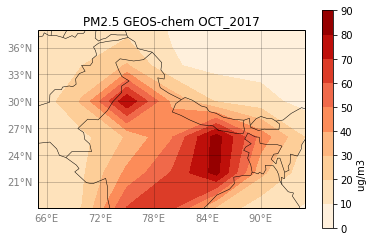

In [12]:
map_2D_GS(GS_IGP,'IJ_SOA_S_PM25', time=9, title='PM2.5 GEOS-chem OCT_2017')

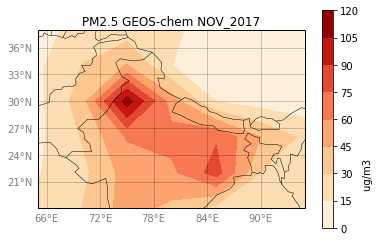

In [13]:
map_2D_GS(GS_IGP,'IJ_SOA_S_PM25', time=10,title='PM2.5 GEOS-chem NOV_2017')

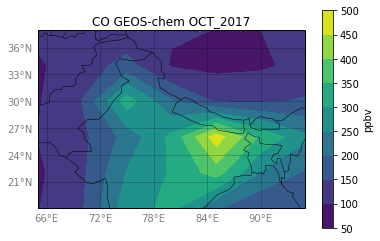

In [14]:
map_2D_GS(GS_IGP,'IJ_AVG_S_CO', time=9, cmap = 'viridis', title='CO GEOS-chem OCT_2017')

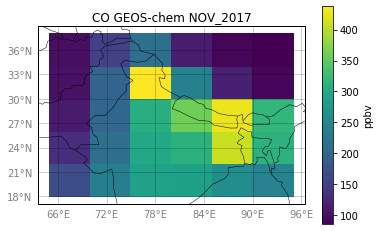

In [55]:
map_2D_GS(GS_IGP,'IJ_AVG_S_CO', time=10, cmap = 'viridis', pixels=True, title='CO GEOS-chem NOV_2017')

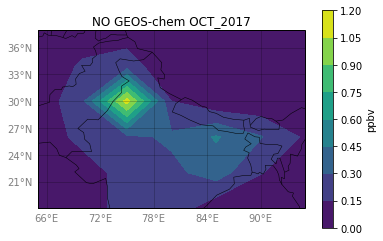

In [16]:
map_2D_GS(GS_IGP,'IJ_AVG_S_NO', time=9,cmap = 'viridis', title='NO GEOS-chem OCT_2017')

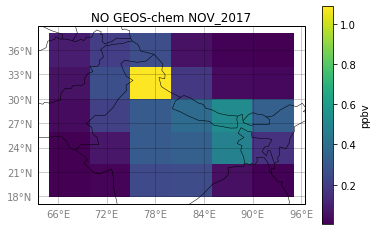

In [57]:
map_2D_GS(GS_IGP,'IJ_AVG_S_NO', time=10, cmap = 'viridis',pixels=True,title='NO GEOS-chem NOV_2017')

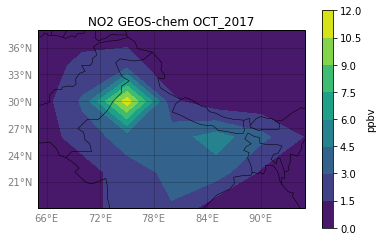

In [18]:
map_2D_GS(GS_IGP,'IJ_AVG_S_NO2', time=9, cmap = 'viridis', title='NO2 GEOS-chem OCT_2017')

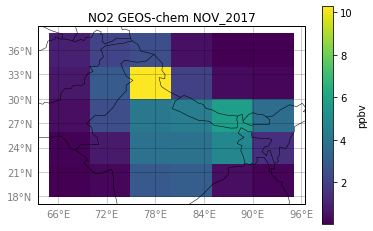

In [56]:
map_2D_GS(GS_IGP,'IJ_AVG_S_NO2', time=10, pixels=True, cmap = 'viridis', title='NO2 GEOS-chem NOV_2017')

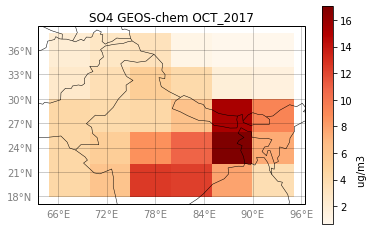

In [58]:
map_2D_GS(GS_IGP,'IJ_SOA_S_SO4', time=9, pixels=True,title='SO4 GEOS-chem OCT_2017')

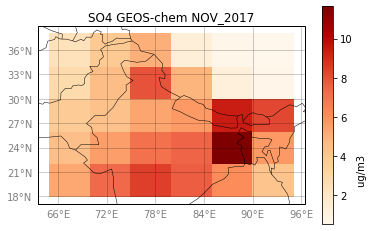

In [59]:
map_2D_GS(GS_IGP,'IJ_SOA_S_SO4', time=10, pixels=True,title='SO4 GEOS-chem NOV_2017')

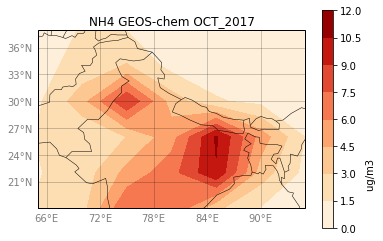

In [23]:
map_2D_GS(GS_IGP,'IJ_SOA_S_NH4', time=9, title='NH4 GEOS-chem OCT_2017')

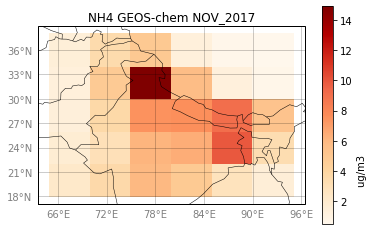

In [61]:
map_2D_GS(GS_IGP,'IJ_SOA_S_NH4', time=10, pixels=True,title='NH4 GEOS-chem NOV_2017')

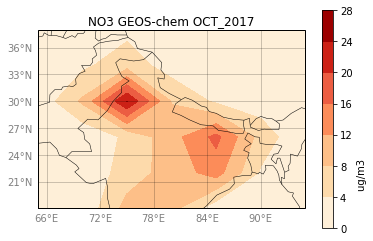

In [27]:
map_2D_GS(GS_IGP,'IJ_SOA_S_NIT', time=9, title='NO3 GEOS-chem OCT_2017')

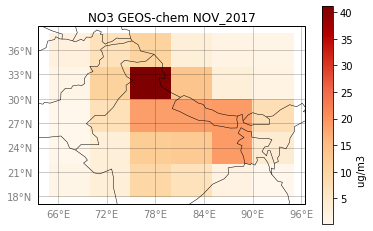

In [60]:
map_2D_GS(GS_IGP,'IJ_SOA_S_NIT', time=10, pixels=True,title='NO3 GEOS-chem NOV_2017')

# WRF-Chem

## Time average of outputs from 18/10 to 16/11 2017

In [29]:
def timeavg(ds):
    """
      Make the average over 'time' dimension of a datarray.
    """
    return xr.Dataset(dict(ds.mean(dim='Time', keep_attrs=True).data_vars), coords = dict(ds.coords))

In [30]:
aer = aer.get_aerosols(WRFchem)

In [31]:
aer_tavg = timeavg(aer)

In [32]:
ds_tavg= timeavg(WRFchem)

In [35]:
def map_2D(dataset, var_name, level=0, mask_values=None,
           title=None, cmap = 'OrRd', coastline=True, borders=True,
           pixels=False, save=False, format='pdf', dpi=1000):

    """
    Plots a 2D-map of a variable at a given time (and level).
    NB: input dataset must already contain only one time value.
    (For set the time if multiples: dataset[0]  or 1,2,3 in the brackets.)
    :param dataset: WRF-Chem output.
    :type dataset: xarray DataSet
    :param var_name: variable name as in the dataset.
    :type var_name: string
    :param level: vertical level at which to plot. Default surface level.
    :type level: integer
    :param mask_values: mask values to plot below a certain level. Default no mask.
    :type mask_values: float 
    :param title: title of the plot. Default no title.
    :type title: string
    :param coastline: plot or not coastline. Default True.
    :type coastline: bool
    :param borders: plot or not borders. Default True.
    :type borders: bool
    :param pixels: plot as pcolormesh (raw pixels). Default False.
    :type pixels: bool
    :param save: save plot to path destination, including figure name. Default False.
    :type save: bool
    :param format: format of the saved plot (pdf, png, eps..), Default pdf.
    :type format: string
    :param dpi: resolution of the saved plot in dots per inches. Default 1000.
    :type dpi: integer
    """
    
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    import numpy as np
    
    
    # ------------------------- DRAW THE MAP --------------------------------
    # draw map.
    ax = plt.subplot(projection=ccrs.PlateCarree())
 
    # draw meridians and parallels.
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='k', alpha=0.4, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'gray'}
    gl.ylabel_style = {'size': 10, 'color': 'grey'}


    # draw coastlines and borders.
    if coastline:
        ax.add_feature(cfeature.COASTLINE, lw=0.5)
    if borders:
        ax.add_feature(cfeature.BORDERS, lw=0.5)

   # ------------------------- GET DATA TO PLOT------------------------------
   
    # get variable from dataset.   
    var = dataset[var_name]
      
    # plot data at desired level.
    long = dataset.XLONG.values[0,:, :]
    lat = dataset.XLAT.values[0,:, :]
    
    if mask_values is None:
        var_values = var[level, :, :]
    else: 
        var_values= np.ma.masked_where(var[level,:,:].values < mask_values,
                                       var[level,:,:].values) 
   

   # -------------------------  PLOT DATA ----------------------------------
    
    #plot type: contourf or pcolormesh.
    if pixels:
        cs = plt.pcolormesh(long, lat,var_values,
            transform=ccrs.PlateCarree(), cmap =cmap) #vmin=vmin, vmax=vmax)
    else:    
        cs = plt.contourf(long, lat, var_values,
            transform=ccrs.PlateCarree(), cmap=cmap) #,vmin=vmin, vmax=vmax)
    
    # colorbar.
    cbar = plt.colorbar(cs)
    cbar.set_label(var.units)
    
    #title.
    ax.set_title(title)
    
    #save
    if save:
        plt.savefig( save + '.' + format, format=format, dpi=dpi)
    
    plt.show()

In [36]:
aer_tavg['so4'] = aer_tavg.pm25_so4 + aer_tavg.so4_a04  # sulfate sum all 4 bins.
aer_tavg.so4.attrs['units'] = 'ug/m3'

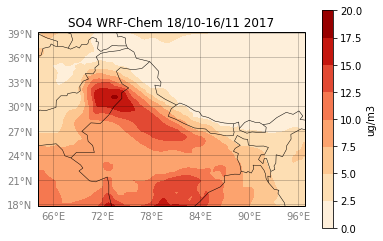

In [37]:
map_2D(aer_tavg, 'so4', title='SO4 WRF-Chem 18/10-16/11 2017')

In [38]:
aer_tavg['nh4'] = aer_tavg.pm25_nh4 + aer_tavg.nh4_a04  #  sum all 4 bins.
aer_tavg.nh4.attrs['units'] = 'ug/m3'

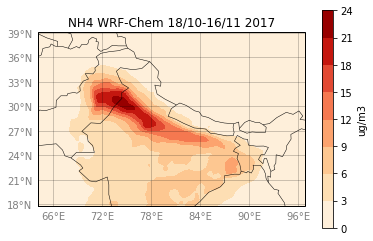

In [39]:
map_2D(aer_tavg, 'nh4', title='NH4 WRF-Chem 18/10-16/11 2017')

In [40]:
aer_tavg['no3'] = aer_tavg.pm25_no3 + aer_tavg.no3_a04  # sum all 4 bins.
aer_tavg.no3.attrs['units'] = 'ug/m3'

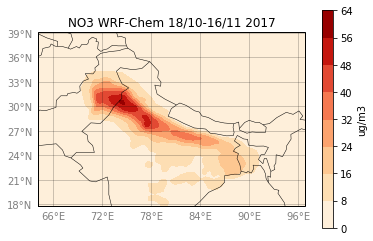

In [41]:
map_2D(aer_tavg, 'no3', title='NO3 WRF-Chem 18/10-16/11 2017')

In [42]:
ds_tavg['co_ppbv'] = ds_tavg.co*1000 # from ppmv to ppbv.
ds_tavg.co_ppbv.attrs['units'] = 'ppbv'

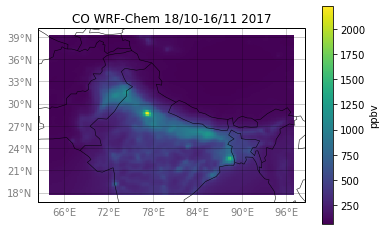

In [53]:
map_2D(ds_tavg,'co_ppbv',cmap='viridis',pixels= True,title='CO WRF-Chem 18/10-16/11 2017')

In [44]:
ds_tavg['no_ppbv'] = ds_tavg.no*1000 # from ppmv to ppbv.
ds_tavg.no_ppbv.attrs['units'] = 'ppbv'

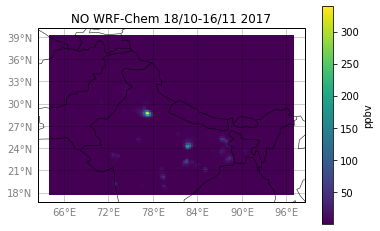

In [52]:
map_2D(ds_tavg, 'no_ppbv',cmap='viridis',pixels= True, title='NO WRF-Chem 18/10-16/11 2017')

In [46]:
ds_tavg['no2_ppbv'] = ds_tavg.no2*1000 # from ppmv to ppbv.
ds_tavg.no2_ppbv.attrs['units'] = 'ppbv'

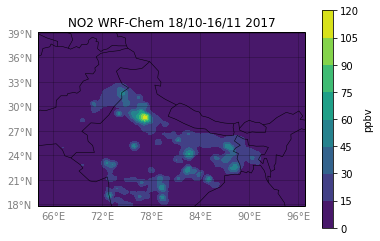

In [51]:
map_2D(ds_tavg, 'no2_ppbv',cmap='viridis', pixels=False, title='NO2 WRF-Chem 18/10-16/11 2017')